In [36]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [38]:
CFG = {
    'fold_num': 5,
    'seed': 0,
    'model': 'efficientnet_lite0',
    'img_size': 256,
    'epochs': 50,
    'train_bs': 10,
    'valid_bs': 10,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-5,
    'num_workers': 0,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0',
    'model_path': './models'
}

In [39]:
model =timm.create_model('efficientnet_lite0', pretrained=True, num_classes=2)

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

In [57]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [58]:
def get_img(path, train_arg=False, sub_path=None):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    if train_arg:
        dimg = cv2.fastNlMeansDenoisingColored(im_rgb, None, 10,10,7,21)
        return dimg
    else:
        return im_rgb

In [59]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class ColonDataset(Dataset):
    def __init__(self, df, data_root, train_arg=False,
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size'], CFG['img_size']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 }
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.train_arg = train_arg
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
        
        img  = get_img("{}/{}".format(self.data_root[index], self.df.loc[index]['image_id']), train_arg=self.train_arg)

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
               
                fmix_img  = get_img("{}/{}".format(self.data_root[fmix_ix], self.df.iloc[fmix_ix]['image_id']), train_arg=self.train_arg)
            

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']), train_arg=self.train_arg)
                
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

In [60]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, 
    ShiftScaleRotate, CenterCrop, Resize, SmallestMaxSize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            #SmallestMaxSize(CFG['img_size']),
            #RandomResizedCrop(CFG['img_size'], CFG['img_size'], p=0.5),
            Resize(CFG['img_size'], CFG['img_size']),   # (h, w)
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
#             GaussNoise(p=0.7),
#             HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [61]:
class ForcepImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class=2, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes=n_class)
        try :
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, n_class)

        except :
            
            try : 
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, n_class)
            
            except :
                try:
                    n_features = self.model.head.fc.in_channels
                    self.model.head.fc = nn.Conv2d(n_features,n_class,kernel_size=(1, 1), stride=(1, 1))
            
                except:
                    n_features = self.model.head.in_features
                    self.model.head = nn.Linear(n_features, n_class)
            
    def forward(self, x):
        x = self.model(x)
        return x

In [62]:
def prepare_dataloader(train, val, train_root=train.dir.values, val_root=val.dir.values):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = train
    valid_ = val
    train_data_root = train_root
    valid_data_root = val_root
    
        
    train_ds = ColonDataset(train_, train_data_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = ColonDataset(valid_, valid_data_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=False,        
        num_workers=CFG['num_workers'],
        sampler=BalanceClassSampler(labels=train_['label'].values, mode="upsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

In [63]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None
    loss_sum = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        #print(image_labels.shape, exam_label.shape)
        with autocast():
            image_preds = model(imgs)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

            loss = loss_fn(image_preds, image_labels)
            loss_sum+=loss
            
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
            
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    accuracy = (image_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    print('train accuracy = {:.5f}'.format(accuracy))
    print(matrix)
    
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
    
    return image_preds_all, accuracy, trn_loss, matrix

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    image_preds_all = []
    image_targets_all = []
    
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  
        
        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    acc = (image_preds_all==image_targets_all).mean()
#     val_loss = avg_loss/len(val_loader)
    val_loss = loss_sum/sample_num 
    
    print('validation accuracy = {:.5f}'.format(acc))
    print(matrix)
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
            
    return image_preds_all, acc, val_loss, matrix

In [64]:
# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

Train Accuracy,▁▆▇▇▇███████████████████████████████████
Train Loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
Valid Accuracy,▁▇▇████▇████▆█▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇█████████
Valid Loss,█▃▂▂▂▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▁▂▁▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Accuracy,1.0
Train Loss,0.00031
Valid Accuracy,1.0
Valid Loss,0.00463
epoch,49


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Training start with epoch 50 



epoch 0 loss: 0.1239: 100%|███████████████████████████████████████████████████████████| 408/408 [01:30<00:00,  4.51it/s]


train accuracy = 0.94799
[[1960   78]
 [ 134 1904]]


epoch 0 loss: 0.0199: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.71it/s]


validation accuracy = 0.99662
[[509   1]
 [  1  81]]


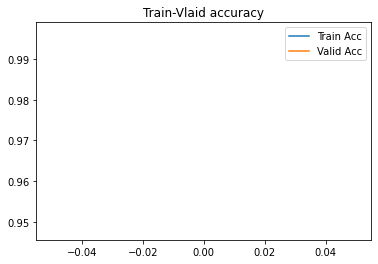

epoch 1 loss: 0.0471: 100%|███████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.74it/s]


train accuracy = 0.98234
[[2000   38]
 [  34 2004]]


epoch 1 loss: 0.0087: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.84it/s]

validation accuracy = 0.99831
[[510   0]
 [  1  81]]


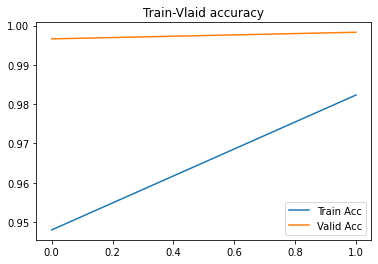

epoch 2 loss: 0.0211: 100%|███████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99362
[[2022   16]
 [  10 2028]]


epoch 2 loss: 0.0068: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.85it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


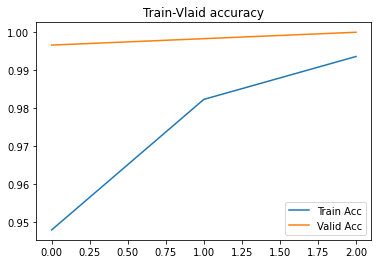

epoch 3 loss: 0.0228: 100%|███████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99190
[[2022   16]
 [  17 2021]]


epoch 3 loss: 0.0049: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.84it/s]

validation accuracy = 0.99831
[[510   0]
 [  1  81]]


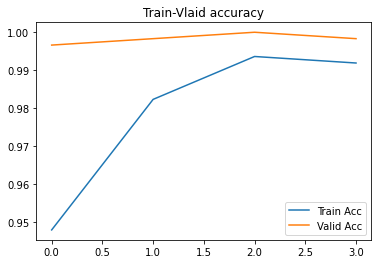

epoch 4 loss: 0.0278: 100%|███████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.73it/s]


train accuracy = 0.99215
[[2021   17]
 [  15 2023]]


epoch 4 loss: 0.0054: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.84it/s]

validation accuracy = 0.99831
[[510   0]
 [  1  81]]


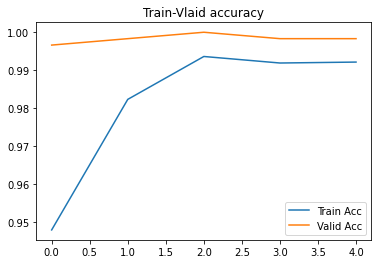

epoch 5 loss: 0.0179: 100%|███████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99583
[[2032    6]
 [  11 2027]]


epoch 5 loss: 0.0091: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.82it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


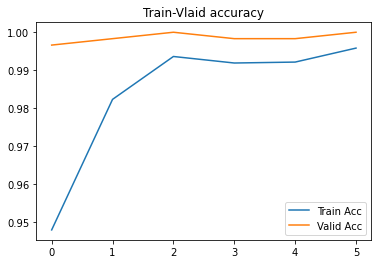

epoch 6 loss: 0.0100: 100%|███████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.73it/s]


train accuracy = 0.99657
[[2028   10]
 [   4 2034]]


epoch 6 loss: 0.0027: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.86it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


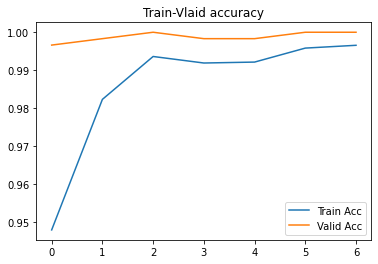

epoch 7 loss: 0.0139: 100%|███████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.71it/s]


train accuracy = 0.99804
[[2035    3]
 [   5 2033]]


epoch 7 loss: 0.0064: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.84it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


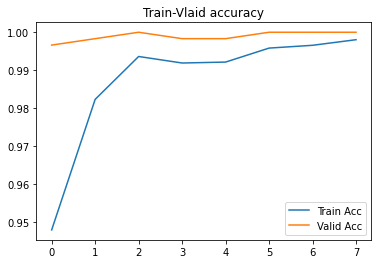

epoch 8 loss: 0.0052: 100%|███████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99779
[[2034    4]
 [   5 2033]]


epoch 8 loss: 0.0028: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.83it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


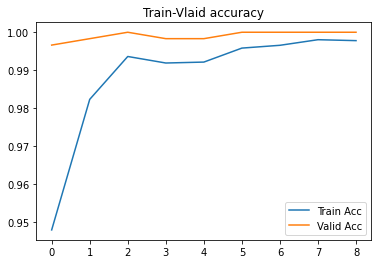

epoch 9 loss: 0.0067: 100%|███████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.71it/s]


train accuracy = 0.99877
[[2034    4]
 [   1 2037]]


epoch 9 loss: 0.0048: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.83it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


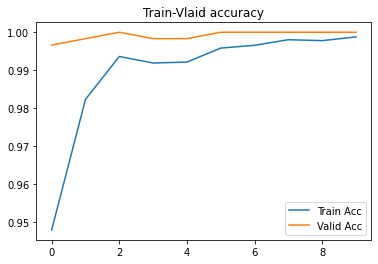

epoch 10 loss: 0.0039: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.73it/s]


train accuracy = 0.99902
[[2035    3]
 [   1 2037]]


epoch 10 loss: 0.0038: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.83it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


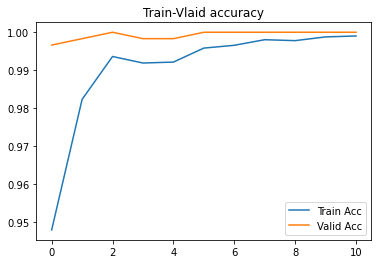

epoch 11 loss: 0.0035: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.69it/s]


train accuracy = 0.99902
[[2035    3]
 [   1 2037]]


epoch 11 loss: 0.0016: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.82it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


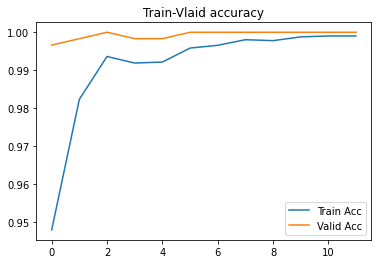

epoch 12 loss: 0.0086: 100%|██████████████████████████████████████████████████████████| 408/408 [01:27<00:00,  4.67it/s]


train accuracy = 0.99853
[[2037    1]
 [   5 2033]]


epoch 12 loss: 0.0043: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.87it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


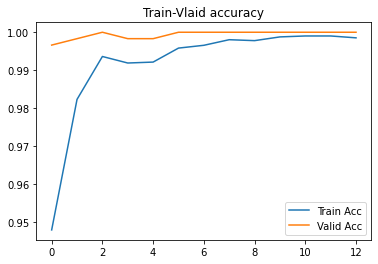

epoch 13 loss: 0.0015: 100%|██████████████████████████████████████████████████████████| 408/408 [01:25<00:00,  4.75it/s]


train accuracy = 0.99975
[[2038    0]
 [   1 2037]]


epoch 13 loss: 0.0016: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.86it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


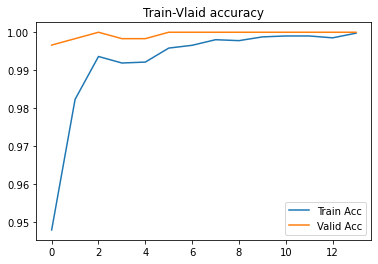

epoch 14 loss: 0.0022: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99926
[[2036    2]
 [   1 2037]]


epoch 14 loss: 0.0022: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.80it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


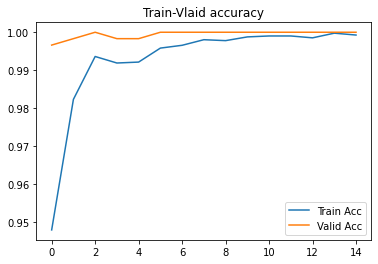

epoch 15 loss: 0.0065: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.71it/s]


train accuracy = 0.99657
[[2027   11]
 [   3 2035]]


epoch 15 loss: 0.0009: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.84it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


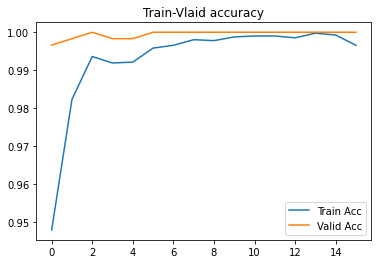

epoch 16 loss: 0.0033: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.71it/s]


train accuracy = 0.99853
[[2034    4]
 [   2 2036]]


epoch 16 loss: 0.0011: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.83it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


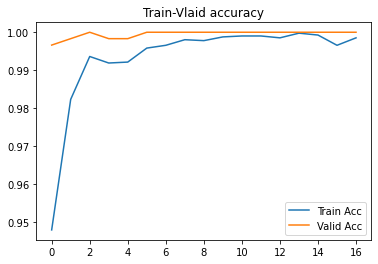

epoch 17 loss: 0.0221: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99804
[[2033    5]
 [   3 2035]]


epoch 17 loss: 0.0029: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.84it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


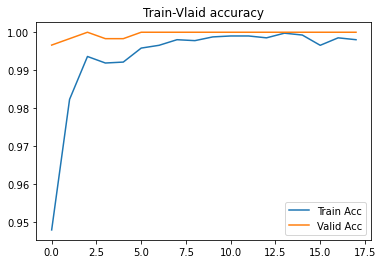

epoch 18 loss: 0.0021: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99975
[[2037    1]
 [   0 2038]]


epoch 18 loss: 0.0011: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.84it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


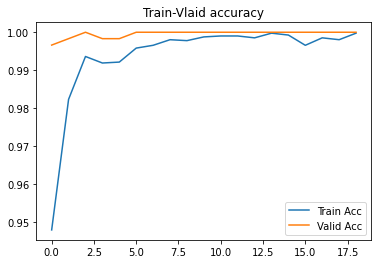

epoch 19 loss: 0.0047: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99607
[[2033    5]
 [  11 2027]]


epoch 19 loss: 0.0021: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.84it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


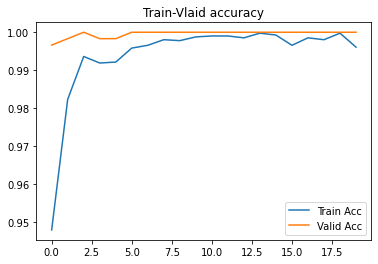

epoch 20 loss: 0.0011: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99975
[[2038    0]
 [   1 2037]]


epoch 20 loss: 0.0030: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.82it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


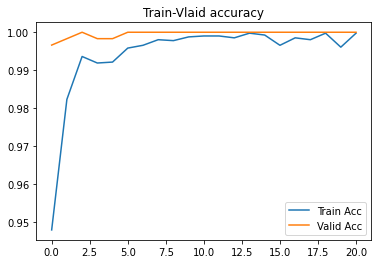

epoch 21 loss: 0.0310: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99828
[[2036    2]
 [   5 2033]]


epoch 21 loss: 0.0018: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.86it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


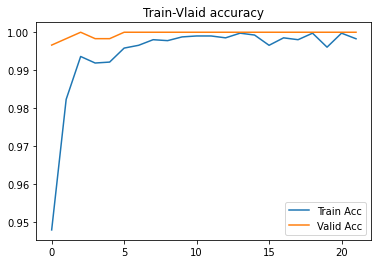

epoch 22 loss: 0.0031: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.71it/s]


train accuracy = 0.99975
[[2038    0]
 [   1 2037]]


epoch 22 loss: 0.0010: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.85it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


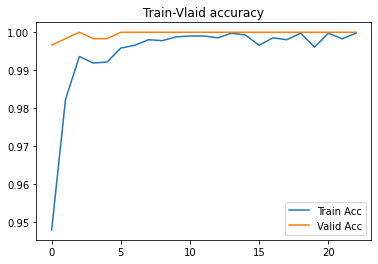

epoch 23 loss: 0.0025: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.71it/s]


train accuracy = 0.99804
[[2031    7]
 [   1 2037]]


epoch 23 loss: 0.0020: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.83it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


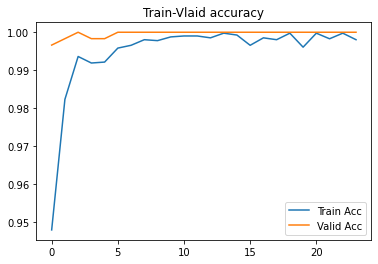

epoch 24 loss: 0.0027: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99975
[[2037    1]
 [   0 2038]]


epoch 24 loss: 0.0036: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.82it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


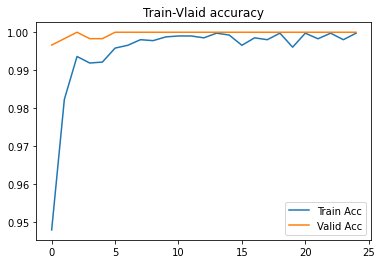

epoch 25 loss: 0.0289: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.73it/s]


train accuracy = 0.99902
[[2038    0]
 [   4 2034]]


epoch 25 loss: 0.0023: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.84it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


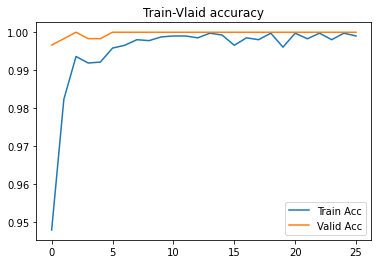

epoch 26 loss: 0.0008: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.73it/s]


train accuracy = 0.99951
[[2037    1]
 [   1 2037]]


epoch 26 loss: 0.0015: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.86it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


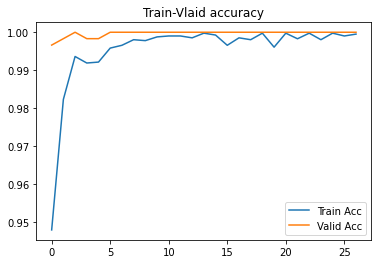

epoch 27 loss: 0.0174: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.71it/s]


train accuracy = 0.99926
[[2037    1]
 [   2 2036]]


epoch 27 loss: 0.0009: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.82it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


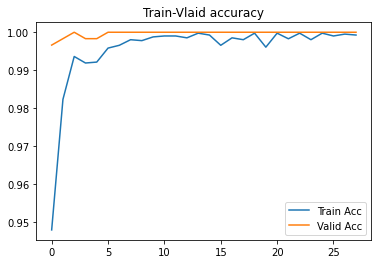

epoch 28 loss: 0.0074: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99902
[[2038    0]
 [   4 2034]]


epoch 28 loss: 0.0014: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.88it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


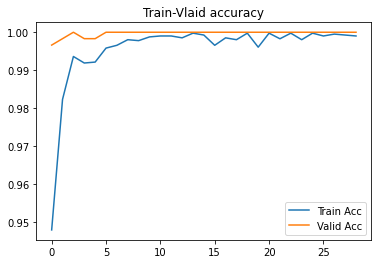

epoch 29 loss: 0.0296: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.74it/s]


train accuracy = 0.99926
[[2036    2]
 [   1 2037]]


epoch 29 loss: 0.0054: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.81it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


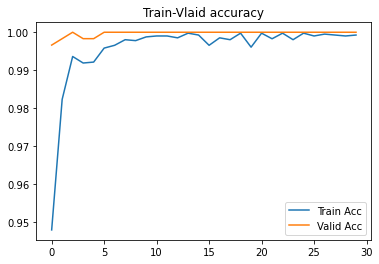

epoch 30 loss: 0.0113: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.71it/s]


train accuracy = 0.99804
[[2031    7]
 [   1 2037]]


epoch 30 loss: 0.0013: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.81it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


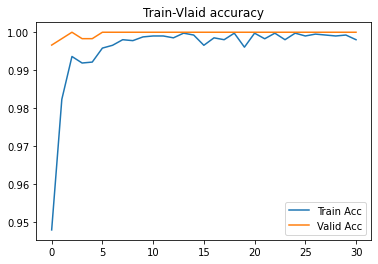

epoch 31 loss: 0.0009: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.73it/s]


train accuracy = 1.00000
[[2038    0]
 [   0 2038]]


epoch 31 loss: 0.0005: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.87it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


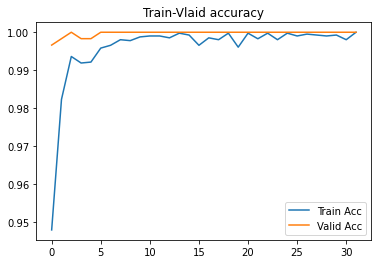

epoch 32 loss: 0.0128: 100%|██████████████████████████████████████████████████████████| 408/408 [01:25<00:00,  4.76it/s]


train accuracy = 0.99607
[[2034    4]
 [  12 2026]]


epoch 32 loss: 0.0014: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.82it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


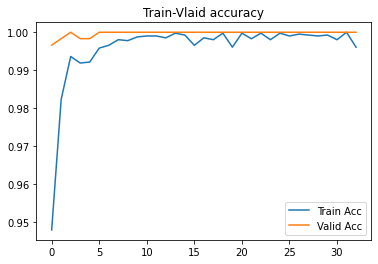

epoch 33 loss: 0.0014: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.73it/s]


train accuracy = 0.99975
[[2038    0]
 [   1 2037]]


epoch 33 loss: 0.0006: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.87it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


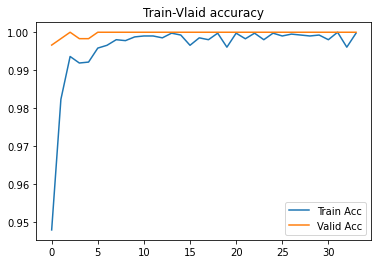

epoch 34 loss: 0.0013: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.71it/s]


train accuracy = 0.99926
[[2035    3]
 [   0 2038]]


epoch 34 loss: 0.0009: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.84it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


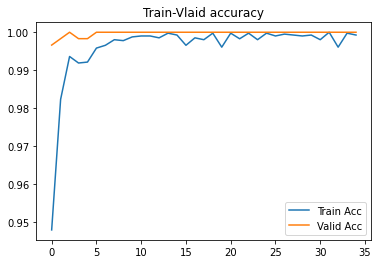

epoch 35 loss: 0.0005: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.74it/s]


train accuracy = 0.99975
[[2038    0]
 [   1 2037]]


epoch 35 loss: 0.0005: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.85it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


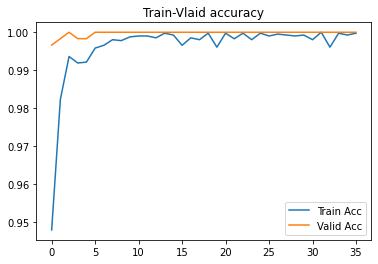

epoch 36 loss: 0.0009: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 1.00000
[[2038    0]
 [   0 2038]]


epoch 36 loss: 0.0002: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.82it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


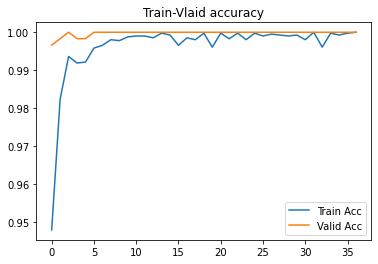

epoch 37 loss: 0.0003: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.73it/s]


train accuracy = 1.00000
[[2038    0]
 [   0 2038]]


epoch 37 loss: 0.0002: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.84it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


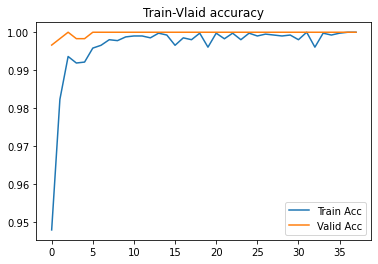

epoch 38 loss: 0.0004: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.71it/s]


train accuracy = 1.00000
[[2038    0]
 [   0 2038]]


epoch 38 loss: 0.0002: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.85it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


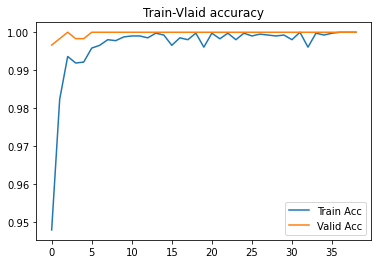

epoch 39 loss: 0.0033: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.71it/s]


train accuracy = 0.99926
[[2035    3]
 [   0 2038]]


epoch 39 loss: 0.0002: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.81it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


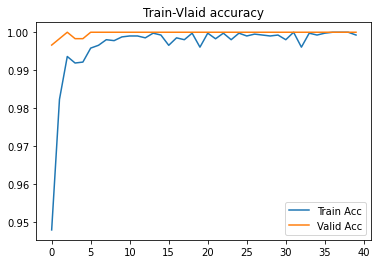

epoch 40 loss: 0.0002: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 1.00000
[[2038    0]
 [   0 2038]]


epoch 40 loss: 0.0003: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.85it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


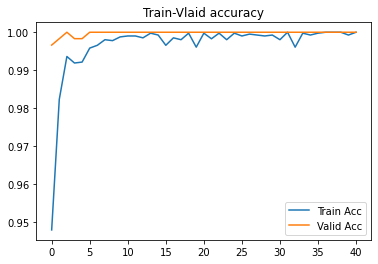

epoch 41 loss: 0.0083: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.73it/s]


train accuracy = 0.99926
[[2038    0]
 [   3 2035]]


epoch 41 loss: 0.0009: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.80it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


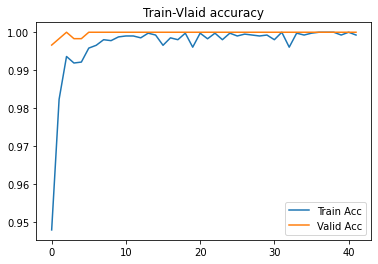

epoch 42 loss: 0.0371: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 0.99804
[[2035    3]
 [   5 2033]]


epoch 42 loss: 0.0015: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.86it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


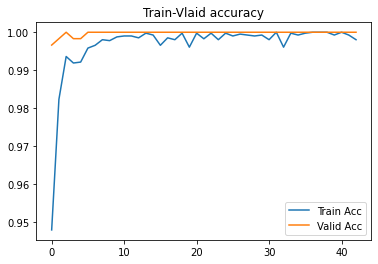

epoch 43 loss: 0.0006: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.73it/s]


train accuracy = 0.99951
[[2037    1]
 [   1 2037]]


epoch 43 loss: 0.0004: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.85it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


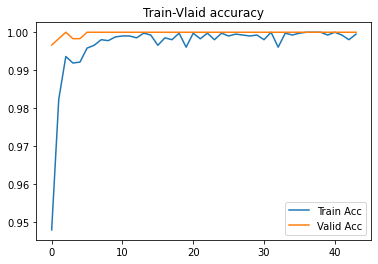

epoch 44 loss: 0.0192: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.71it/s]


train accuracy = 0.99926
[[2035    3]
 [   0 2038]]


epoch 44 loss: 0.0101: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.83it/s]

validation accuracy = 0.99831
[[510   0]
 [  1  81]]


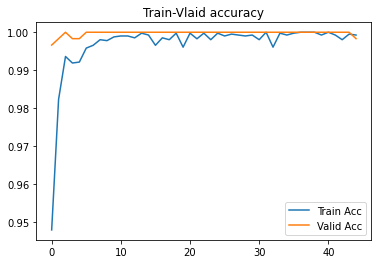

epoch 45 loss: 0.0031: 100%|██████████████████████████████████████████████████████████| 408/408 [01:25<00:00,  4.76it/s]


train accuracy = 0.99902
[[2037    1]
 [   3 2035]]


epoch 45 loss: 0.0007: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.83it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


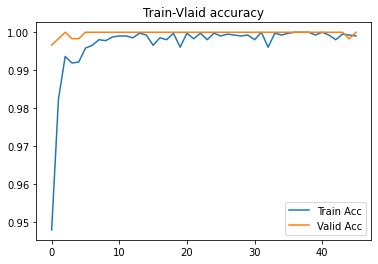

epoch 46 loss: 0.0011: 100%|██████████████████████████████████████████████████████████| 408/408 [01:25<00:00,  4.75it/s]


train accuracy = 0.99975
[[2037    1]
 [   0 2038]]


epoch 46 loss: 0.0033: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.87it/s]

validation accuracy = 0.99831
[[510   0]
 [  1  81]]


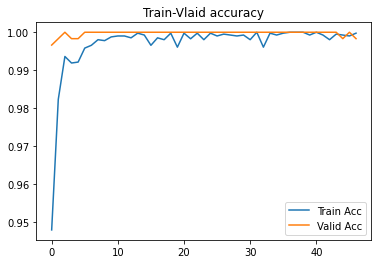

epoch 47 loss: 0.0003: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 1.00000
[[2038    0]
 [   0 2038]]


epoch 47 loss: 0.0004: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.83it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


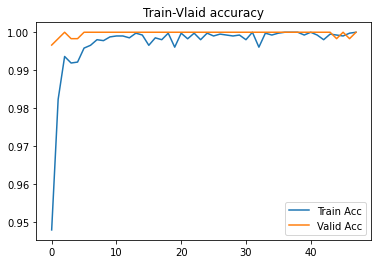

epoch 48 loss: 0.0008: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.70it/s]


train accuracy = 0.99975
[[2038    0]
 [   1 2037]]


epoch 48 loss: 0.0006: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.86it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


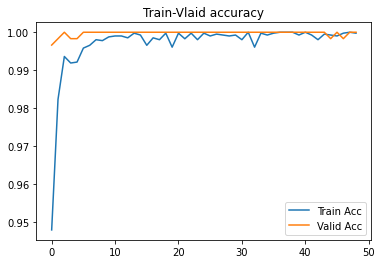

epoch 49 loss: 0.0004: 100%|██████████████████████████████████████████████████████████| 408/408 [01:26<00:00,  4.72it/s]


train accuracy = 1.00000
[[2038    0]
 [   0 2038]]


epoch 49 loss: 0.0003: 100%|████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.81it/s]

validation accuracy = 1.00000
[[510   0]
 [  0  82]]


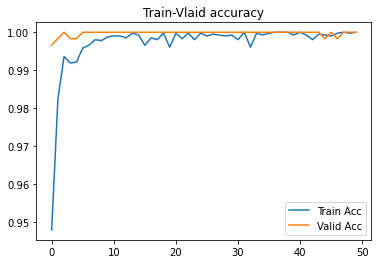

time : 1:20:47
Best Epoch : 2/ 50
Best Train Accuracy : 0.99362
[[2022   16]
 [  10 2028]]
Best Valid Accuracy : 1.00000
[[510   0]
 [  0  82]]


In [66]:
model_dir = '{}'.format(CFG['model'])
train_dir = train.dir.values
val_dir = val.dir.values


if __name__ == '__main__':
     # for training only, need nightly build pytorch
    wandb.init(project=project_name, entity=user)
    
#     wandb.login()
#     wandb.init(project="3class classification")
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train-Vlaid accuracy", step_metric="epoch")
    
    seed_everything(CFG['seed'])
    
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
#     folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
#     for fold, (trn_idx, val_idx) in enumerate(folds):
#         break
    
#     print(f'Training start with epoch {CFG["epochs"]} \n')

  
    train_loader, val_loader = prepare_dataloader(train, val, train_root=train_dir, val_root=val_dir)

    device = torch.device(CFG['device'])

    model = ForcepImgClassifier(CFG['model'], train.label.nunique(), pretrained=True).to(device)
    
    scaler = GradScaler()   
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], 
#                                      weight_decay=CFG['weight_decay']
                                )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=25)
#         scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
    #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))

    loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
    loss_fn = nn.CrossEntropyLoss().to(device)

    wandb.watch(model, loss_tr, log='all')
    
    train_acc_list = []
    train_matrix_list = []
    valid_acc_list = []
    valid_matrix_list = []

    start = time.time()
    for epoch in range(CFG['epochs']):

        train_preds_all, train_acc, train_loss, train_matrix = train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, 
                                                                   scheduler=scheduler, schd_batch_update=False)
        wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'epoch' : epoch})
        
        with torch.no_grad():
            valid_preds_all, valid_acc, valid_loss, valid_matrix= valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)
            wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'epoch' : epoch})
            
        torch.save(model.state_dict(), (model_dir+'/20%_drop_{}_{}').format(CFG['model'], epoch))

        train_acc_list.append(train_acc)
        train_matrix_list.append(train_matrix)
        valid_acc_list.append(valid_acc)
        valid_matrix_list.append(valid_matrix)
        
        fig = plt.figure().add_subplot(1, 1, 1)
        fig.plot(train_acc_list, label='Train Acc')
        fig.plot(valid_acc_list, label='Valid Acc')
        fig.set_title('Train-Vlaid accuracy')
        fig.legend()
        wandb.log({'Train-Vlaid accuracy': wandb.Image(fig)})
        plt.show()

    end = time.time() - start
    time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
    print("time :", time_)

    best_index = valid_acc_list.index(max(valid_acc_list))
    print(f'Best Epoch : {best_index}/ {len(valid_acc_list)}')
    print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
    print(train_matrix_list[best_index])
    print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
    print(valid_matrix_list[best_index])

#     torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))

    del model, optimizer, train_loader, val_loader, scaler
    torch.cuda.empty_cache()

    train_preds_all = train_preds_all
    valid_preds_all = valid_preds_all